# End-to-end demo of the ``stadv`` package
We use a small CNN pre-trained on MNIST and try and fool the network using *Spatially Transformed Adversarial Examples* (stAdv).

### Import the relevant libraries

In [1]:
%matplotlib inline

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
import os
import numpy as np
import tensorflow as tf
import stadv

# dependencies specific to this demo notebook
import matplotlib.pyplot as plt
import idx2numpy

### Load MNIST data
The test data for the MNIST dataset should be downloaded from http://yann.lecun.com/exdb/mnist/,
decompressed, and put in a directory ``mnist_data_dir``.

This can be done in command line with:
```
wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz && gunzip -f t10k-images-idx3-ubyte.gz
wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz && gunzip -f t10k-labels-idx1-ubyte.gz
```

In [2]:
mnist_data_dir = '.'
mnist_images = idx2numpy.convert_from_file(os.path.join(mnist_data_dir, 't10k-images-idx3-ubyte'))
mnist_labels = idx2numpy.convert_from_file(os.path.join(mnist_data_dir, 't10k-labels-idx1-ubyte'))
mnist_images = np.expand_dims(mnist_images, -1)

print("Shape of images:", mnist_images.shape)
print("Range of values: from {} to {}".format(np.min(mnist_images), np.max(mnist_images)))
print("Shape of labels:", mnist_labels.shape)
print("Range of values: from {} to {}".format(np.min(mnist_labels), np.max(mnist_labels)))

Shape of images: (10000, 28, 28, 1)
Range of values: from 0 to 255
Shape of labels: (10000,)
Range of values: from 0 to 9


### Definition of the graph
The CNN we consider is using the `layers` module of TensorFlow. It was heavily inspired by this tutorial: https://www.tensorflow.org/tutorials/layers

In [3]:
# definition of the inputs to the network
images = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='images')
flows = tf.placeholder(tf.float32, [None, 2, 28, 28], name='flows')
targets = tf.placeholder(tf.int64, shape=[None], name='targets')
tau = tf.placeholder_with_default(
    tf.constant(0., dtype=tf.float32),
    shape=[], name='tau'
)

# flow-based spatial transformation layer
perturbed_images = stadv.layers.flow_st(images, flows, 'NHWC')

# definition of the CNN in itself
conv1 = tf.layers.conv2d(
    inputs=perturbed_images,
    filters=32,
    kernel_size=[5, 5],
    padding="same",
    activation=tf.nn.relu
)
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
conv2 = tf.layers.conv2d(
    inputs=pool1,
    filters=64,
    kernel_size=[5, 5],
    padding="same",
    activation=tf.nn.relu
)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
logits = tf.layers.dense(inputs=pool2_flat, units=10)

# definition of the losses pertinent to our study
L_adv = stadv.losses.adv_loss(logits, targets)
L_flow = stadv.losses.flow_loss(flows, padding_mode='CONSTANT')
L_final = L_adv + tau * L_flow
grad_op = tf.gradients(L_final, flows, name='loss_gradient')[0]

### Import the learned weights
The network has been trained independently and its learned weights are shipped with the demo. The final error on the test set is of 1.3%.

In [4]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

sess = tf.Session()
sess.run(init)
saver.restore(sess, os.path.join('saved_models', 'simple_mnist'))

INFO:tensorflow:Restoring parameters from saved_models/simple_mnist


### Test the model on a single image
The test image is randomly picked from the test set of MNIST. Its target label is also selected randomly.

In [5]:
i_random_image = np.random.randint(0, len(mnist_images))
test_image = mnist_images[i_random_image]
test_label = mnist_labels[i_random_image]
random_target = np.random.choice([num for num in range(10) if num != test_label])

print("Considering image #", i_random_image, "from the test set of MNIST")
print("Ground truth label:", test_label)
print("Randomly selected target label:", random_target)

# reshape so as to have a first dimension (batch size) of 1
test_image = np.expand_dims(test_image, 0)
test_label = np.expand_dims(test_label, 0)
random_target = np.expand_dims(random_target, 0)

# with no flow the flow_st is the identity
null_flows = np.zeros((1, 2, 28, 28))

pred_label = np.argmax(sess.run(
    [logits],
    feed_dict={images: test_image, flows: null_flows}
))

print("Predicted label (no perturbation):", pred_label)

Considering image # 701 from the test set of MNIST
Ground truth label: 0
Randomly selected target label: 2
Predicted label (no perturbation): 0


### Where the magic takes place
Optimization of the flow so as to minimize the loss using an L-BFGS-B optimizer.

In [6]:
results = stadv.optimization.lbfgs(
    L_final,
    flows,
    # random initial guess for the flow
    flows_x0=np.random.random_sample((1, 2, 28, 28)),
    feed_dict={images: test_image, targets: random_target, tau: 0.05},
    grad_op=grad_op,
    sess=sess
)

print("Final loss:", results['loss'])
print("Optimization info:", results['info'])

test_logits_perturbed, test_image_perturbed = sess.run(
    [logits, perturbed_images],
    feed_dict={images: test_image, flows: results['flows']}
)
pred_label_perturbed = np.argmax(test_logits_perturbed)

print("Predicted label after perturbation:", pred_label_perturbed)

Final loss: 3.042147397994995
Optimization info: {'warnflag': 0, 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'grad': array([-8.85338522e-07,  3.08994227e-03,  9.12457518e-03, ...,
        1.18389018e-02,  2.62641702e-02,  2.19407566e-02]), 'nit': 8, 'funcalls': 73}
Predicted label after perturbation: 2


### Show the results

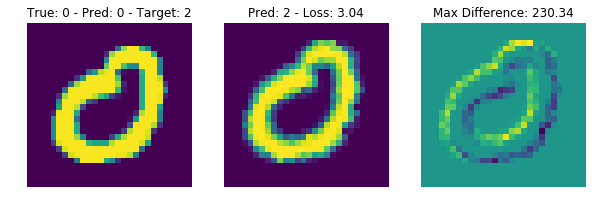

In [7]:
image_before = test_image[0, :, :, 0]
image_after = test_image_perturbed[0, :, :, 0]

difference = image_after - image_before
max_diff = abs(difference).max()

plt.rcParams['figure.figsize'] = [10, 10]

f, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.imshow(image_before)
ax1.set_title("True: {} - Pred: {} - Target: {}".format(test_label[0], pred_label, random_target[0]))
ax1.axis('off')
ax2.imshow(image_after)
ax2.set_title("Pred: {} - Loss: {}".format(pred_label_perturbed, round(results['loss'], 2)))
ax2.axis('off')
ax3.imshow(difference)
ax3.set_title("Max Difference: {}".format(round(max_diff, 2)))
ax3.axis('off')
plt.show()